In [1]:
import os
from typing import Tuple, Dict, List, Union, Any, Optional, Literal
import argparse
import random
import warnings

import h5py
import yaml
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from tqdm import tqdm

from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from weaver.nn.model import ParticleNet

from modules import data, eval, exec, fix_seed, file_util

2023-09-10 20:01:21.365411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
# dir_path = "/home/suzukiy/ftag/particlenet-ftag/models/particlenet/u020-GN1-22M-re-re"
dir_path = "/home/suzukiy/ftag/particlenet-ftag/models/parT/GN1-pt-22M"

with open(os.path.join(dir_path, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

history = pd.read_csv(os.path.join(dir_path, "history.csv"))
history = history[:100]
history

epoch  train_loss  train_acc  train_btag_rej_c  train_btag_rej_l  \
0       0    1.316154   0.655114          2.903455         14.576263   
1       1    1.250886   0.676771          3.347590         19.566647   
2       2    1.231215   0.683174          3.528536         21.583937   
3       3    1.220792   0.686648          3.599472         22.456917   
4       4    1.213527   0.689066          3.727896         23.926376   
..    ...         ...        ...               ...               ...   
95     95    1.132930   0.715327          4.835747         33.724337   
96     96    1.131928   0.715749          4.886480         34.269462   
97     97    1.130617   0.716058          4.866433         33.983349   
98     98    1.130252   0.716279          4.923815         34.656830   
99     99    1.129609   0.716508          4.956218         34.877319   

    train_ctag_rej_b  train_ctag_rej_l  val_loss   val_acc  val_btag_rej_c  \
0           2.022428          2.150282  1.279256  0.666133        3.142637   
1           2.258649          2.340883  1.248683  0.677138        3.395427   
2           2.331289          2.381795  1.237633  0.681051        3.511927   
3           2.367834          2.400146  1.236752  0.681922        3.538406   
4           2.395447          2.414102  1.229210  0.684511        3.528901   
..               ...               ...       ...       ...             ...   
95          2.812106          2.720997  1.249720  0.684678        3.819493   
96          2.799549          2.685281  1.237599  0.687754        3.944960   
97          2.807953          2.690497  1.251557  0.684825        3.814320   
98          2.813244          2.700564  1.248759  0.685306        3.850345   
99          2.809575          2.685705  1.243916  0.686130        3.864794   

    val_btag_rej_l  val_ctag_rej_c  val_ctag_rej_l  
0        17.508798        2.312671        2.165609  
1        20.046588        2.309508        2.291461  
2        21.129603        2.357500        2.311954  
3        21.539833        2.433316        2.294881  
4        22.132830        2.446293        2.332188  
..             ...             ...             ...  
95       21.399955        2.634389        2.196580  
96       22.279503        2.622106        2.244318  
97       21.670964        2.655704        2.200865  
98       21.947478        2.658318        2.207712  
99       21.884703        2.638735        2.213570  

[100 rows x 13 columns]

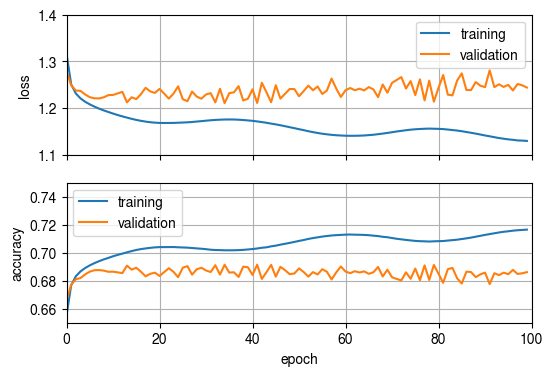

In [14]:
%matplotlib inline

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(history["train_loss"], label="training")
ax[0].plot(history["val_loss"], label="validation")
ax[0].set_ylabel("loss")
ax[0].set_ylim(1.1, 1.4)

ax[1].plot(history["train_acc"], label="training")
ax[1].plot(history["val_acc"], label="validation")
ax[1].set_ylabel("accuracy")
ax[1].set_ylim(0.65, 0.75)

# ax[2].plot(history["train_btag_rej_c"], label="train")
# ax[2].plot(history["val_btag_rej_c"], label="validation")
# ax[2].set_ylabel("c-jet rejection")

# ax[3].plot(history["train_btag_rej_l"], label="train")
# ax[3].plot(history["val_btag_rej_l"]
# ax[3].set_ylabel("light-jet rejection")

# ax[3].plot(history["train_ctag_rej_b"], label="train_rej_b")
# ax[3].plot(history["val_ctag_rej_b"], label="valid_rej_b")
# ax[3].plot(history["train_ctag_rej_l"], label="train_rej_l")
# ax[3].plot(history["val_ctag_rej_l"], label="valid_rej_l")

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
    # ax[i].set_yscale("log")

ax[-1].set(
    xlabel="epoch",
    xlim=(0, len(history)),
)


# plt.savefig(os.path.join(dir_path, "history.pdf"), bbox_inches="tight")
plt.savefig(os.path.join("comparisons", "parT_history.pdf"), bbox_inches="tight")
plt.show()
# print(os.path.join(dir_path, "history.pdf"))

In [11]:
dir_path = "/home/suzukiy/ftag/particlenet-ftag/models/particlenet/u020-GN1-22M-re-re"
# dir_path = "/home/suzukiy/ftag/particlenet-ftag/models/parT/GN1-pt-22M"

with open(os.path.join(dir_path, "config.yaml"), "r") as f:
    config = yaml.safe_load(f)

history = pd.read_csv(os.path.join(dir_path, "history.csv"))
history = history[:100]
history

epoch  train_loss  train_acc  train_btag_rej_c  train_btag_rej_l  \
0       0    1.358629   0.640705          2.666422         12.111474   
1       1    1.302460   0.659475          2.876669         14.385869   
2       2    1.275810   0.668148          3.010955         15.540010   
3       3    1.271743   0.669712          3.081641         16.192129   
4       4    1.256983   0.674505          3.254760         17.977811   
..    ...         ...        ...               ...               ...   
95     95    1.209139   0.691237          3.679886         23.340569   
96     96    1.211320   0.690539          3.664285         23.181836   
97     97    1.211145   0.690577          3.702522         23.594069   
98     98    1.210989   0.690633          3.661500         23.125211   
99     99    1.210826   0.690697          3.724199         23.844058   

    train_ctag_rej_b  train_ctag_rej_l  val_loss   val_acc  val_btag_rej_c  \
0           1.889400          2.087014  1.334284  0.648502        2.666422   
1           2.038878          2.182230  1.305002  0.657786        2.876669   
2           2.146323          2.286239  1.294451  0.661531        3.010955   
3           2.144938          2.244353  1.282889  0.665737        3.081641   
4           2.209130          2.315379  1.269453  0.670396        3.254760   
..               ...               ...       ...       ...             ...   
95          2.406082          2.466947  1.231139  0.684523        3.679886   
96          2.369887          2.392778  1.230922  0.684408        3.664285   
97          2.370062          2.389263  1.230902  0.684337        3.702522   
98          2.377338          2.405383  1.230615  0.684423        3.661500   
99          2.383123          2.420150  1.230938  0.684542        3.724199   

    val_btag_rej_l  val_ctag_rej_b  val_ctag_rej_l  
0        12.111474        1.889400        2.087014  
1        14.385869        2.038878        2.182230  
2        15.540010        2.146323        2.286239  
3        16.192129        2.144938        2.244353  
4        17.977811        2.209130        2.315379  
..             ...             ...             ...  
95       23.340569        2.406082        2.466947  
96       23.181836        2.369887        2.392778  
97       23.594069        2.370062        2.389263  
98       23.125211        2.377338        2.405383  
99       23.844058        2.383123        2.420150  

[100 rows x 13 columns]

In [12]:
%matplotlib inline

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(history["train_loss"], label="training")
ax[0].plot(history["val_loss"], label="validation")
ax[0].set_ylabel("loss")
ax[0].set_ylim(1.1, 1.4)

ax[1].plot(history["train_acc"], label="training")
ax[1].plot(history["val_acc"], label="validation")
ax[1].set_ylabel("accuracy")
ax[1].set_ylim(0.65, 0.75)

# ax[2].plot(history["train_btag_rej_c"], label="train")
# ax[2].plot(history["val_btag_rej_c"], label="validation")
# ax[2].set_ylabel("c-jet rejection")

# ax[3].plot(history["train_btag_rej_l"], label="train")
# ax[3].plot(history["val_btag_rej_l"]
# ax[3].set_ylabel("light-jet rejection")

# ax[3].plot(history["train_ctag_rej_b"], label="train_rej_b")
# ax[3].plot(history["val_ctag_rej_b"], label="valid_rej_b")
# ax[3].plot(history["train_ctag_rej_l"], label="train_rej_l")
# ax[3].plot(history["val_ctag_rej_l"], label="valid_rej_l")

for i in range(len(ax)):
    ax[i].legend()
    ax[i].grid()
    # ax[i].set_yscale("log")

ax[-1].set(
    xlabel="epoch",
    xlim=(0, len(history)),
)


# plt.savefig(os.path.join(dir_path, "history.pdf"), bbox_inches="tight")
plt.savefig(os.path.join("comparisons", "partn_history.pdf"), bbox_inches="tight")
plt.show()
# print(os.path.join(dir_path, "history.pdf"))